In [8]:
import ee
import geemap
import requests
import geopandas as gpd
import numpy as np
from functools import reduce
from geopandas import GeoDataFrame
from shapely.geometry import Point,Polygon
import pandas as pd

# Initialize the Earth Engine module
ee.Initialize()

In [2]:
#########################################################################
############################ USER INPUTS ################################
#########################################################################
# DOMAIN
# choose the modeling domain
domain = 'WY'
print(domain)

domains_resp = requests.get("https://raw.githubusercontent.com/snowmodel-tools/preprocess_python/master/CSO_domains.json")
domains = domains_resp.json()
    
# PATHS
# path to domain data folder 
dataPath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/'
# path to store tif files from gee
#TIFpath = '/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/GEE/'
# # path to where you want your output met .dat fime
# OUTpath = 'OR_met_test.dat'#'/nfs/attic/dfh/Aragon2/CSOdmn/'+domain+'/mm_'+domain+'_2011-2016.dat'

# TIME
# choose if want to set 'manual' or 'auto' date 
date_flag = 'manual'
# If you choose 'manual' set your dates below  
# This will start on the 'begin' date at 0:00 and the last iteration will 
# be on the day before the 'end' date below.
st_dt = '2011-09-01'#domains[domain]['st']
stdt=st_dt
ed_dt = '2016-10-01'#domains[domain]['ed']
eddt=ed_dt
#########################################################################

WY


In [3]:
#path to SNOTEL gdf
gdfpath = dataPath+'CSO_SNOTEL_sites_'+domain+'.geojson'

# station data
stn_gdf = gpd.read_file(gdfpath)
stn_gdf.head()

,code,longitude,latitude,name,elevation_m,easting,northing,geometry
0,314_WY_SNTL,-110.445442,43.940189,Base Camp,2151.887939453125,544505.845453,4.865379e+06,POINT (-110.44544 43.94019)
1,347_MT_SNTL,-111.128029,44.508320,Black Bear,2490.216064453125,489823.440274,4.928341e+06,POINT (-111.12803 44.50832)
2,350_WY_SNTL,-109.793327,44.376671,Blackwater,2980.944091796875,596129.923439,4.914418e+06,POINT (-109.79333 44.37667)
3,353_WY_SNTL,-110.609734,42.964001,Blind Bull Sum,2636.52001953125,531828.554679,4.756891e+06,POINT (-110.60973 42.96400)
4,419_WY_SNTL,-110.814819,42.645901,Cottonwood Creek,2337.81591796875,515180.157295,4.721511e+06,POINT (-110.81482 42.64590)


In [4]:
cfsv2 = ee.ImageCollection("NOAA/CFSV2/FOR6H").filterDate(stdt,eddt)
cfsv2_select = cfsv2.select('Temperature_height_above_ground', 'Precipitation_rate_surface_6_Hour_Average')

In [87]:
list_of_bands = ['Temperature_height_above_ground', 'Precipitation_rate_surface_6_Hour_Average']

for i in range(len(stn_gdf)):
    code = stn_gdf.code[i]
    pt = ee.Geometry.Point(stn_gdf.geometry.x[i], stn_gdf.geometry.y[i])
    temp_point = cfsv2_select.getRegion(pt, scale = 22200).getInfo()
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(temp_point)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)
    
    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors='coerce')
    
    if i == 0:
        df['datetime'] = pd.to_datetime(df['time'], unit='ms')
        df_temp = pd.DataFrame(index = df.datetime)
        df_prcp = pd.DataFrame(index = df.datetime)
        
    #put T in C
    temp = df['Temperature_height_above_ground']-273.16
    df_temp[code]=temp.values


    #convert precip rate to precip DEPTH (mm) during time interval
    pr = df['Precipitation_rate_surface_6_Hour_Average']*24*3600/4
    df_prcp[code]=pr.values

# Compare precipitation data

In [80]:
# Resample to daily precip sum and save as new dataframe
pr_daily = df_prcp.resample('D').sum()
pr_daily

,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,419_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,497_WY_SNTL,499_WY_SNTL,...,764_WY_SNTL,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL
datetime,,,,,,,,,,,,,,,,,,,,,
2011-09-01,0.0000,0.2376,0.0000,0.0000,0.0000,0.0000,0.0000,0.1944,0.0000,0.0864,...,0.0000,0.0000,0.0000,0.0000,0.0432,0.0648,0.0000,0.0000,0.0000,0.0000
2011-09-02,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2011-09-03,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2011-09-04,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2011-09-05,0.4104,0.0000,0.0864,0.6912,0.6264,0.2808,0.0216,1.1664,0.7344,0.0648,...,0.1296,0.8424,0.8424,0.0000,0.0000,0.0000,0.2808,0.8424,0.1512,0.6264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-26,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2016-09-27,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2016-09-28,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [54]:
# load the precip data from snotel 
eddt = '2016-09-30'
dftemp = pd.read_csv(dataPath+'SNOTEL_'+domain+'_PRmeters'+stdt+'_'+eddt+'.csv') 
dftemp['datetime']=pd.to_datetime(dftemp[dftemp.columns[0]])
stn_pr=dftemp.set_index(dftemp.datetime,drop=True)
stn_pr

,Unnamed: 0,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,419_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,497_WY_SNTL,...,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2011-09-01,2011-09-01,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,...,0.00000,0.00254,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.0,2011-09-01
2011-09-02,2011-09-02,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,...,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.00254,0.0,2011-09-02
2011-09-03,2011-09-03,0.0,0.0,0.00000,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,...,0.00000,0.00254,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.0,2011-09-03
2011-09-04,2011-09-04,0.0,0.0,0.01016,0.00254,0.00000,0.00000,0.0,0.00000,0.00000,...,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,0.00000,0.0,2011-09-04
2011-09-05,2011-09-05,0.0,0.0,0.00762,0.00000,0.00000,0.00000,0.0,0.00000,0.00000,...,0.00254,0.00000,0.0,0.0,0.00254,0.00000,0.0,0.00254,0.0,2011-09-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-26,2016-09-26,0.0,0.0,0.00000,0.00000,0.00254,0.00000,0.0,0.00508,0.00000,...,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,NaN,0.0,2016-09-26
2016-09-27,2016-09-27,0.0,0.0,0.00000,0.00254,0.00000,0.00000,0.0,0.00000,0.00000,...,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,NaN,0.0,2016-09-27
2016-09-28,2016-09-28,0.0,0.0,0.00000,0.00000,0.00254,0.00000,0.0,0.00000,0.00000,...,0.00000,0.00000,0.0,0.0,0.00000,0.00000,0.0,NaN,0.0,2016-09-28


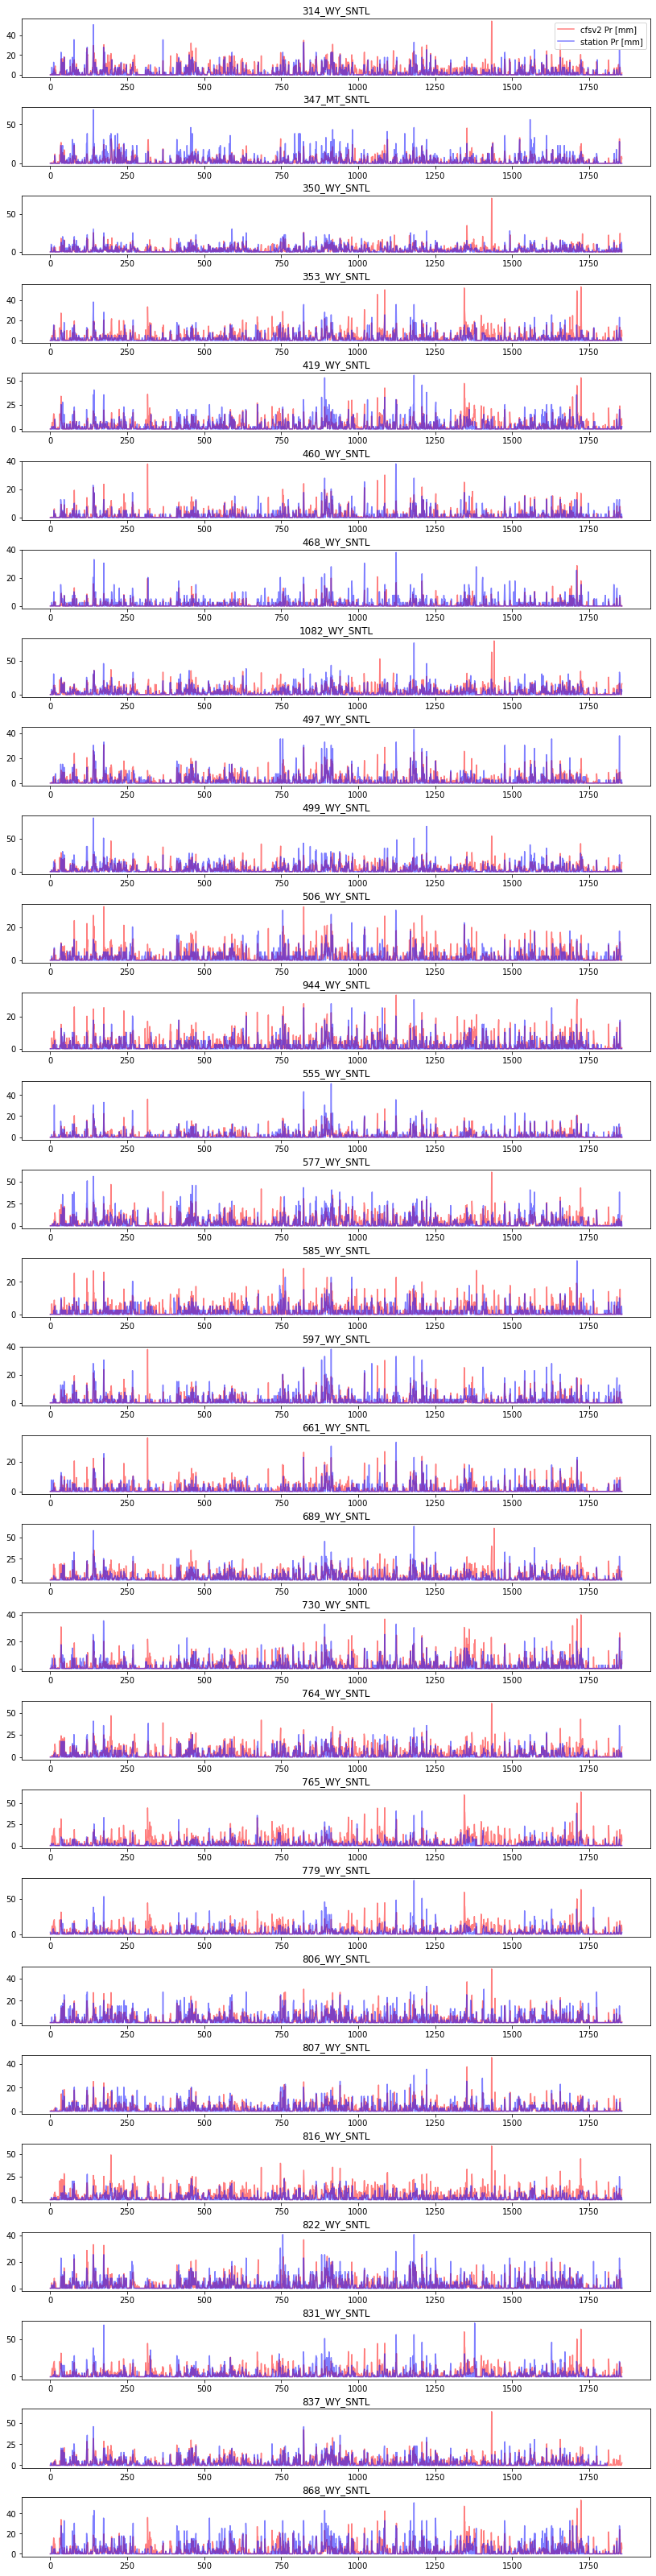

In [78]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(nrows=len(stn_gdf), figsize=(14, 2*len(stn_gdf)), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(len(stn_gdf)):
    nam = stn_gdf.code[i]
    
    mod = pr_daily[stn_gdf.code[i]].values
    
    stn = stn_pr[stn_gdf.code[i]].values*1000
    
    
    axs[i].plot(mod,'r',label = 'cfsv2 Pr [mm]',alpha = .5)
    axs[i].plot(stn,'b',label = 'station Pr [mm]',alpha = .5)
    axs[i].set_title(nam)
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend()

In [94]:
# evaluate annual biases 
pr_yr = df_prcp.resample('Y').sum()

stn_resample = stn_pr.resample('Y').sum()
stn_resample = stn_resample*1000

dif = pd.DataFrame(index = pr_yr.index)
for code in stn_gdf.code:
    dif[code] = pr_yr[code].values-stn_resample[code].values
    print(code,np.mean(pr_yr[code].values-stn_resample[code].values))
    
dif

314_WY_SNTL 372.889866984178
347_MT_SNTL -254.04479930211448
350_WY_SNTL 44.29960251839055
353_WY_SNTL 355.909600512701
419_WY_SNTL 154.89533434258308
460_WY_SNTL 79.8824004416061
468_WY_SNTL -205.34399916169036
1082_WY_SNTL 325.86986871065943
497_WY_SNTL 102.97239981462441
499_WY_SNTL 191.02706683693373
506_WY_SNTL 248.3068008423443
944_WY_SNTL 268.57626620947053
555_WY_SNTL 24.30319984255532
577_WY_SNTL 316.38453421673745
585_WY_SNTL 224.06853370656233
597_WY_SNTL -83.52426622505975
661_WY_SNTL 123.36319984255499
689_WY_SNTL 410.25506746999616
730_WY_SNTL 177.97693415393258
764_WY_SNTL 579.6978675500706
765_WY_SNTL 698.4359997004016
779_WY_SNTL 409.7226663670694
806_WY_SNTL 12.917734944099541
807_WY_SNTL 116.40266781581651
816_WY_SNTL 742.49973340544
822_WY_SNTL -85.05613296886678
831_WY_SNTL 314.0493330337363
837_WY_SNTL 199.8486668161005
868_WY_SNTL -32.64133232408358


,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,419_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,497_WY_SNTL,499_WY_SNTL,...,764_WY_SNTL,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL
datetime,,,,,,,,,,,,,,,,,,,,,
2011-12-31,2.056001,-79.004000,-73.901600,96.375200,51.892803,18.589600,-69.938399,28.636799,58.440000,-37.742400,...,99.837602,253.389600,134.009600,-64.989600,-12.157599,177.343200,-14.505600,100.989600,-14.344801,-37.007197
2012-12-31,392.384002,-543.418399,33.500802,375.543998,80.881600,207.574399,-258.264799,396.534404,144.987197,165.829603,...,674.028801,751.288002,405.848002,84.046402,127.896001,852.842402,-51.049600,337.268002,197.623999,-135.018400
2013-12-31,499.962400,-299.736799,-27.173599,454.453602,268.138400,85.672001,-203.168799,340.408003,173.426400,256.029602,...,665.731204,846.552799,605.252799,-53.458397,114.784803,821.152000,-114.036002,493.492799,178.428803,-67.141600
2014-12-31,614.772798,-337.980799,48.078404,234.879205,-154.920797,43.384003,-353.475998,330.518397,39.500002,144.620798,...,732.044800,642.154400,184.954400,34.958403,152.159203,1039.658401,-89.880797,7.154400,272.345602,-292.080797
2015-12-31,400.572802,-168.274400,217.460808,593.920800,506.319203,95.950399,-259.582400,558.559207,107.112799,369.596797,...,774.472797,1056.564799,751.764799,60.096001,122.825600,944.752800,-135.383999,594.284799,271.563999,298.039203
2016-12-31,327.591199,-95.854399,67.832801,380.284799,177.060798,28.124001,-87.633600,300.562403,94.368001,247.828001,...,532.072001,640.666399,376.506399,16.853600,192.907999,619.249599,-105.480799,351.106399,293.474398,37.360798


# Compare temperature data

In [88]:
temp_daily = df_temp.resample('D').mean()
temp_daily

,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,419_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,497_WY_SNTL,499_WY_SNTL,...,764_WY_SNTL,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL
datetime,,,,,,,,,,,,,,,,,,,,,
2011-09-01,9.734753,10.730755,9.768757,10.305256,11.357754,11.984249,13.789249,12.455250,10.405742,11.808246,...,10.874248,10.578251,10.578251,9.736255,9.962253,10.279758,9.504749,10.578251,9.995746,11.357754
2011-09-02,8.434498,9.771999,7.466999,9.502994,9.867496,10.072994,10.797497,9.585010,9.445995,9.251003,...,8.689495,9.439998,9.439998,6.282497,6.529499,8.424000,7.562000,9.439998,7.470501,9.867496
2011-09-03,9.168499,11.189503,6.833004,8.808506,9.087505,9.876003,10.988003,10.194500,9.089496,10.172001,...,9.334995,8.621494,8.621494,6.982502,7.205501,8.435001,8.118503,8.621494,7.818500,9.087505
2011-09-04,10.847256,12.116245,8.121754,9.888248,10.438244,11.207744,11.974247,12.346752,10.761249,11.970249,...,10.996250,9.166752,9.166752,8.528248,8.005756,10.111248,9.474750,9.166752,9.493252,10.438244
2011-09-05,9.893253,13.072254,8.632747,9.333759,10.083752,9.487255,10.117756,13.074749,9.989750,13.029743,...,11.853260,8.679256,8.679256,8.401745,8.496250,11.531254,7.376751,8.679256,8.560245,10.083752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-26,6.804752,8.743244,6.410251,6.905247,6.762256,8.895748,9.994747,7.867252,7.956257,8.382747,...,7.201252,6.764255,6.764255,6.417744,7.005749,7.103748,6.055248,6.764255,5.963253,6.762256
2016-09-27,7.882747,10.630245,7.615253,9.119755,9.295750,9.633251,10.327747,10.972736,9.086750,10.706745,...,9.198749,8.813251,8.813251,6.614239,7.395244,8.663746,6.577747,8.813251,6.598247,9.295750
2016-09-28,10.875248,12.760242,8.091747,9.707256,10.058246,10.855747,11.032245,12.405750,10.372257,12.782749,...,11.685245,9.012752,9.012752,9.244251,8.860256,11.085255,9.086246,9.012752,9.610744,10.058246


In [89]:
# load the precip data from snotel 
eddt = '2016-09-30'
dftemp = pd.read_csv(dataPath+'SNOTEL_'+domain+'_TAVGcelsius'+stdt+'_'+eddt+'.csv') 
dftemp['datetime']=pd.to_datetime(dftemp[dftemp.columns[0]])
stn_temp=dftemp.set_index(dftemp.datetime,drop=True)
stn_temp

,Unnamed: 0,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,419_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,497_WY_SNTL,...,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL,datetime
datetime,,,,,,,,,,,,,,,,,,,,,
2011-09-01,2011-09-01,10.3,9.3,9.1,10.1,10.8,13.8,13.3,8.6,10.9,...,11.0,11.3,9.2,8.1,8.7,8.5,11.2,7.8,11.3,2011-09-01
2011-09-02,2011-09-02,8.8,8.7,8.3,9.0,9.5,11.7,11.6,7.8,9.1,...,10.5,10.0,7.2,7.9,8.0,6.8,9.9,6.3,10.6,2011-09-02
2011-09-03,2011-09-03,9.9,8.8,3.9,9.3,9.8,10.7,10.9,9.0,9.3,...,8.5,10.1,8.4,6.8,7.4,6.2,7.7,6.9,11.2,2011-09-03
2011-09-04,2011-09-04,10.5,11.5,9.4,10.6,10.7,12.3,12.2,11.1,10.1,...,8.9,10.9,8.6,8.4,8.3,8.3,8.0,8.4,12.5,2011-09-04
2011-09-05,2011-09-05,12.9,14.4,11.8,11.9,12.5,14.3,13.7,12.2,12.1,...,10.1,12.0,11.9,12.2,11.7,10.6,10.5,10.9,13.8,2011-09-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-09-26,2016-09-26,8.1,9.0,8.3,7.4,7.7,11.0,10.4,8.0,9.1,...,8.8,8.1,6.5,7.3,7.2,6.9,6.4,NaN,8.3,2016-09-26
2016-09-27,2016-09-27,9.5,11.1,9.3,9.5,9.9,12.2,12.1,10.1,10.0,...,9.7,10.4,8.1,8.1,7.7,8.5,7.1,NaN,11.2,2016-09-27
2016-09-28,2016-09-28,10.8,12.2,9.8,10.9,11.4,12.1,12.1,12.0,10.4,...,9.5,11.1,10.4,8.4,8.5,9.4,7.4,NaN,13.4,2016-09-28


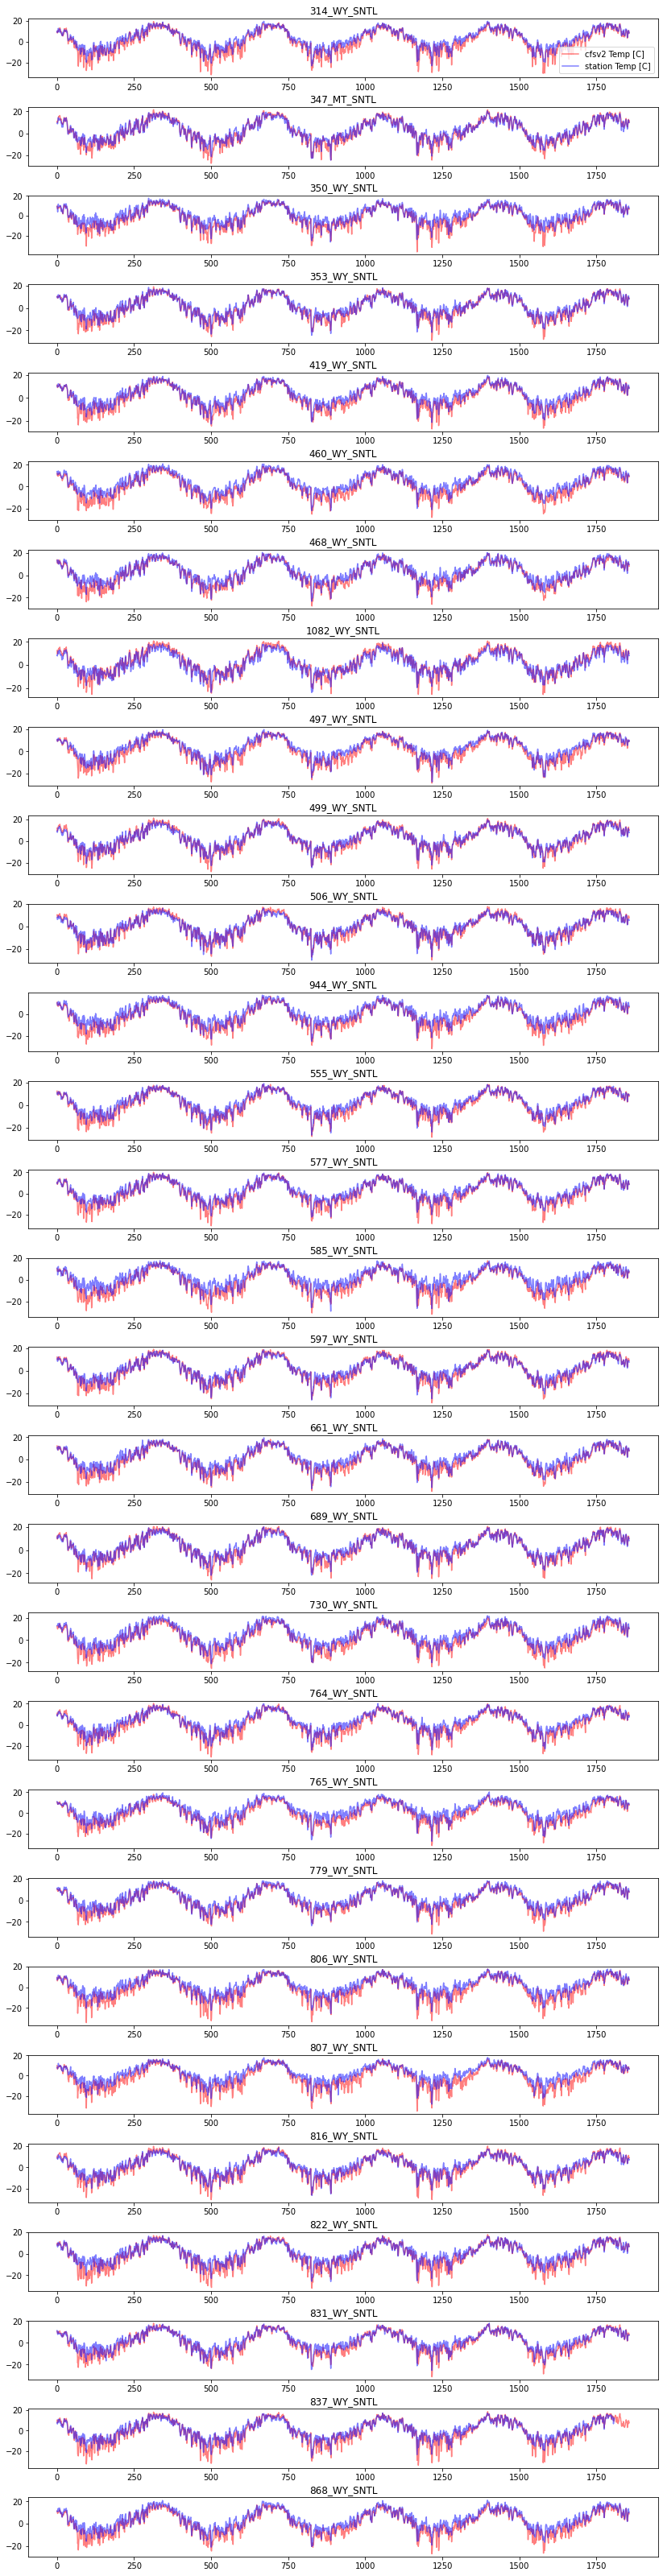

In [90]:
fig, axs = plt.subplots(nrows=len(stn_gdf), figsize=(14, 2*len(stn_gdf)), ncols=1, facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.5)

axs = axs.ravel()
# 1, 2, 3, 4, 5, 
for i in range(len(stn_gdf)):
    nam = stn_gdf.code[i]
    
    mod = temp_daily[stn_gdf.code[i]].values
    
    stn = stn_temp[stn_gdf.code[i]].values
    
    
    axs[i].plot(mod,'r',label = 'cfsv2 Temp [C]',alpha = .5)
    axs[i].plot(stn,'b',label = 'station Temp [C]',alpha = .5)
    axs[i].set_title(nam)
    #axs[i].set_ylim([0, 2])
    if i == 0:
        axs[i].legend()

In [92]:
# evaluate annual biases 
temp_yr = df_temp.resample('Y').mean()

stn_resample = stn_temp.resample('Y').mean()
stn_resample = stn_resample

dif = pd.DataFrame(index = temp_yr.index)
for code in stn_gdf.code:
    dif[code] = temp_yr[code].values-stn_resample[code].values
    print(code,np.mean(temp_yr[code].values-stn_resample[code].values))
    
dif

314_WY_SNTL -2.6942263022174373
347_MT_SNTL -0.8843381284313719
350_WY_SNTL -2.8103778616064936
353_WY_SNTL -1.3972109132190944
419_WY_SNTL -2.533637176834905
460_WY_SNTL -3.2660101854617953
468_WY_SNTL -2.0673433107003727
1082_WY_SNTL 0.6810017561200871
497_WY_SNTL -2.669601228031284
499_WY_SNTL -0.5606308834622411
506_WY_SNTL -0.5772196121836414
944_WY_SNTL -3.1062603801123
555_WY_SNTL -2.1470384748047464
577_WY_SNTL -2.0715403612656167
585_WY_SNTL -3.694673139468955
597_WY_SNTL -1.212362627631058
661_WY_SNTL -2.3626530645297454
689_WY_SNTL -0.9688861596617692
730_WY_SNTL -2.9864037963334416
764_WY_SNTL -2.0279986325605277
765_WY_SNTL -3.0973350291497206
779_WY_SNTL -2.062468600492039
806_WY_SNTL -3.272098418881709
807_WY_SNTL -3.6383257003583416
816_WY_SNTL -1.2399750253336783
822_WY_SNTL -2.3618149224842466
831_WY_SNTL -1.8624462693918151
837_WY_SNTL -1.5764821611462987
868_WY_SNTL -2.9601491449459263


,314_WY_SNTL,347_MT_SNTL,350_WY_SNTL,353_WY_SNTL,419_WY_SNTL,460_WY_SNTL,468_WY_SNTL,1082_WY_SNTL,497_WY_SNTL,499_WY_SNTL,...,764_WY_SNTL,765_WY_SNTL,779_WY_SNTL,806_WY_SNTL,807_WY_SNTL,816_WY_SNTL,822_WY_SNTL,831_WY_SNTL,837_WY_SNTL,868_WY_SNTL
datetime,,,,,,,,,,,,,,,,,,,,,
2011-12-31,-3.194485,-1.684244,-3.359005,-2.556006,-3.074883,-4.426154,-3.482695,-0.551961,-2.900269,-0.958978,...,-2.259203,-3.385559,-3.007690,-3.811891,-3.520771,-1.745330,-4.107665,-2.719165,-2.850670,-3.736358
2012-12-31,-2.158179,-0.584083,-2.567490,-1.088078,-2.115992,-3.119379,-1.788105,1.424089,-2.378967,-0.096144,...,-1.626808,-2.497312,-1.626820,-3.153664,-3.504404,-0.959822,-1.968630,-1.315344,-1.288875,-2.547686
2013-12-31,-2.837370,-1.022244,-2.764344,-1.159535,-2.517943,-3.074718,-1.816814,0.665400,-2.726112,-0.641143,...,-2.080306,-3.207620,-1.978853,-3.175653,-3.811358,-1.349193,-2.175419,-1.853373,-1.655638,-2.820409
2014-12-31,-2.832697,-0.735990,-2.571517,-1.237026,-2.533812,-3.041667,-1.804217,0.796487,-2.746235,-0.779073,...,-2.262530,-3.440375,-1.851608,-3.110615,-3.606189,-1.315553,-1.965008,-1.818183,-1.620599,-2.820113
2015-12-31,-2.569797,-0.756563,-3.044412,-1.276972,-2.524294,-2.983317,-1.831308,0.630621,-2.514120,-0.393895,...,-1.910362,-3.057549,-2.096727,-3.275013,-3.670216,-1.162228,-2.156779,-1.808782,-1.757039,-2.964568
2016-12-31,-2.572829,-0.522904,-2.555499,-1.065648,-2.434899,-2.950826,-1.680920,1.121375,-2.751904,-0.494553,...,-2.028782,-2.995596,-1.813115,-3.105755,-3.717017,-0.907724,-1.797387,-1.659830,-0.286072,-2.871760
